In [4]:
!pip install geopandas rioxarray xarray earthpy shapely

In [5]:
from glob import glob
import os

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import box

data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

In [6]:
modis_bands_pre_list = glob(os.path.join("cold-springs-fire","modis","reflectance","07_july_2016","crop","*_sur_refl_b*.tif"))

modis_bands_pre_list.sort()
modis_bands_pre_list

['cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b01_1.tif',
 'cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b02_1.tif',
 'cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b03_1.tif',
 'cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b04_1.tif',
 'cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b05_1.tif',
 'cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b06_1.tif',
 'cold-springs-fire/modis/reflectance/07_july_2016/crop/MOD09GA.A2016189.h09v05.006.2016191073856_sur_refl_b07_1.tif']

In [7]:
def combine_tifs(tif_list):
    out_xr = []
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True).squeeze())
        out_xr[i]["band"] = i+1

    return xr.concat(out_xr, dim="band")

In [8]:
modis_bands_pre = combine_tifs(modis_bands_pre_list)

/home/codespace/.python/current/lib/python3.10/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


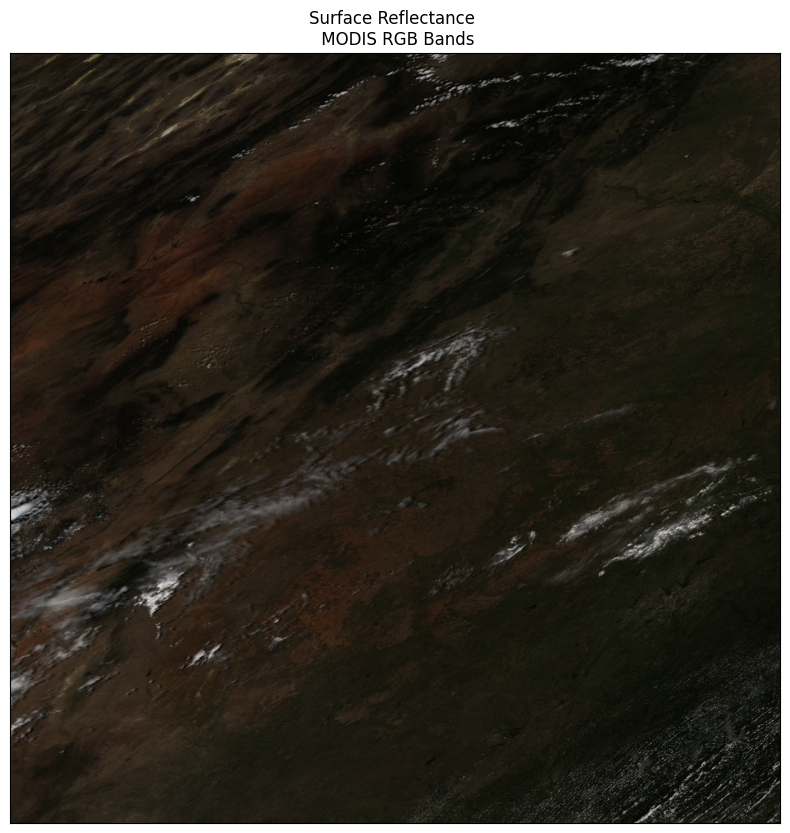

In [9]:
ep.plot_rgb(modis_bands_pre.values,
            rgb=[0, 3, 2],
            title="Surface Reflectance \n MODIS RGB Bands")
plt.show()

In [10]:
print(modis_bands_pre[1].min(), modis_bands_pre[1].max())

<xarray.DataArray ()> Size: 4B
array(-100., dtype=float32)
Coordinates:
    band         int64 8B 2
    spatial_ref  int64 8B 0 <xarray.DataArray ()> Size: 4B
array(10039., dtype=float32)
Coordinates:
    band         int64 8B 2
    spatial_ref  int64 8B 0


/home/codespace/.python/current/lib/python3.10/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


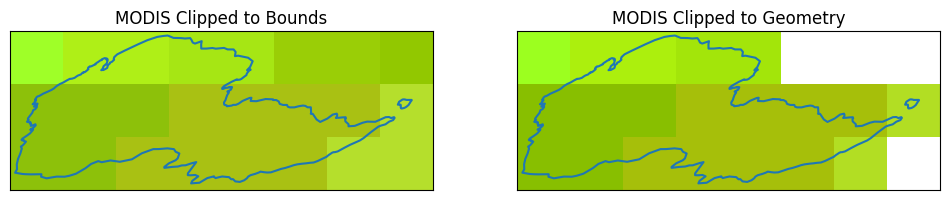

In [11]:
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")
fire_boundary = gpd.read_file(fire_boundary_path)
fire_bound_sin = fire_boundary.to_crs(modis_bands_pre.rio.crs)

fire_bound_box = [box(*fire_bound_sin.total_bounds)]

modis_clip_geometry = modis_bands_pre.rio.clip(fire_bound_sin.geometry,
                                               all_touched=True,
                                               from_disk=True)

modis_clip = modis_bands_pre.rio.clip(fire_bound_box,
                                      all_touched=True,
                                      from_disk=True)

extent = plotting_extent(modis_clip[0].values, modis_clip.rio.transform())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 15))

ep.plot_rgb(modis_clip.values,
            rgb=[0, 3, 2],
            ax=ax1,
            extent=extent,
            title='MODIS Clipped to Bounds')

fire_bound_sin.boundary.plot(ax=ax1)

ep.plot_rgb(modis_clip_geometry.values,
            rgb=[0, 3, 2],
            ax=ax2,
            extent=extent,
            title='MODIS Clipped to Geometry')

fire_bound_sin.boundary.plot(ax=ax2)

plt.show()

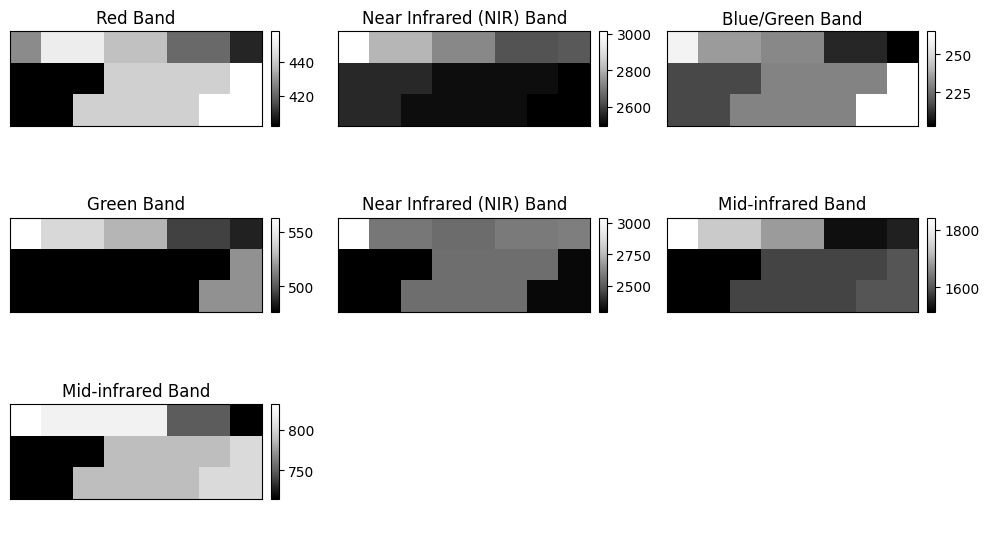

In [12]:
titles = ["Red Band", "Near Infrared (NIR) Band", "Blue/Green Band", "Green Band",
          "Near Infrared (NIR) Band", "Mid-infrared Band", "Mid-infrared Band"]

ep.plot_bands(modis_clip,
              cols=3,
              title=titles,
              figsize=(10, 6))
plt.show()

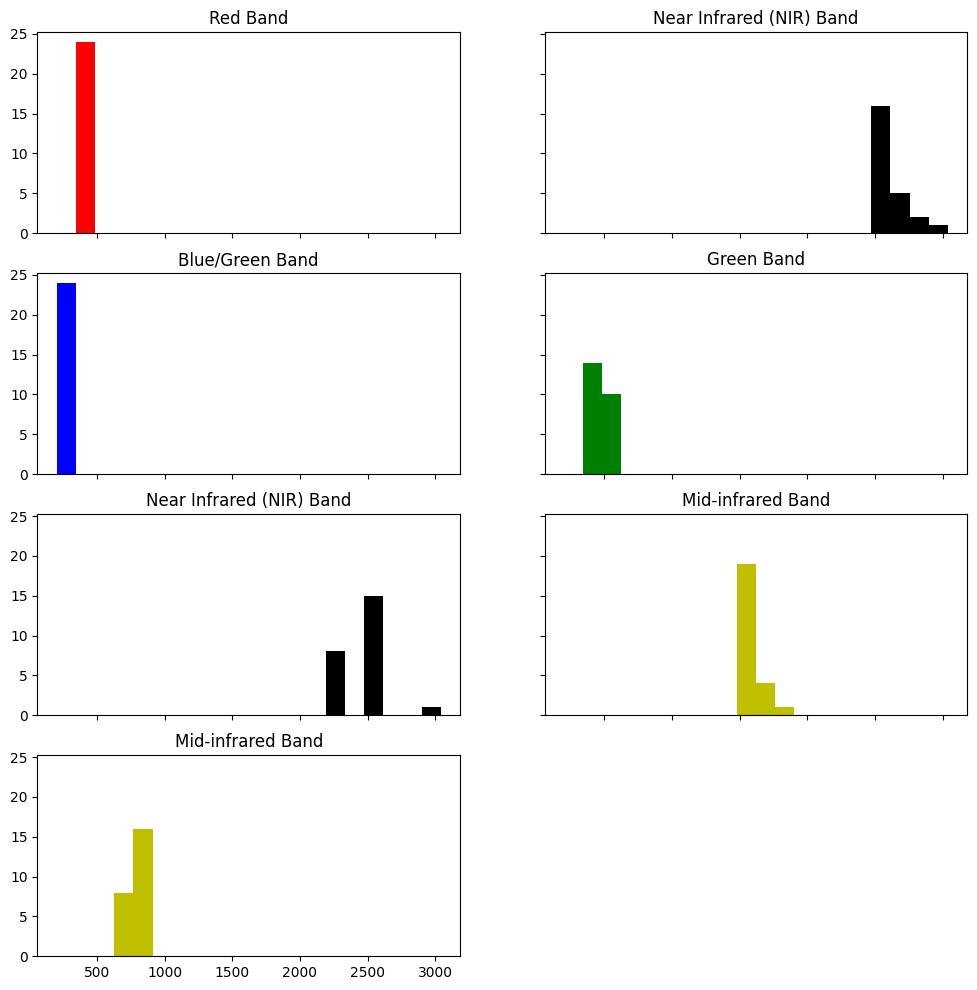

In [13]:
colors = ['r', 'k', 'b', 'g', 'k', 'y', 'y']
titles = ["Red Band", "Near Infrared (NIR) Band", "Blue/Green Band",
          "Green Band", "Near Infrared (NIR) Band",
          "Mid-infrared Band", "Mid-infrared Band"]

ep.hist(modis_clip.values,
        colors=colors,
        title=titles,
        cols=2)
plt.show()

In [14]:
modis_bands_pre_scaled = modis_clip * 0.0001

In [15]:
print(modis_bands_pre_scaled[1].min(), modis_bands_pre_scaled[1].max())

<xarray.DataArray ()> Size: 4B
array(0.2496, dtype=float32)
Coordinates:
    band         int64 8B 2
    spatial_ref  int64 8B 0 <xarray.DataArray ()> Size: 4B
array(0.3013, dtype=float32)
Coordinates:
    band         int64 8B 2
    spatial_ref  int64 8B 0


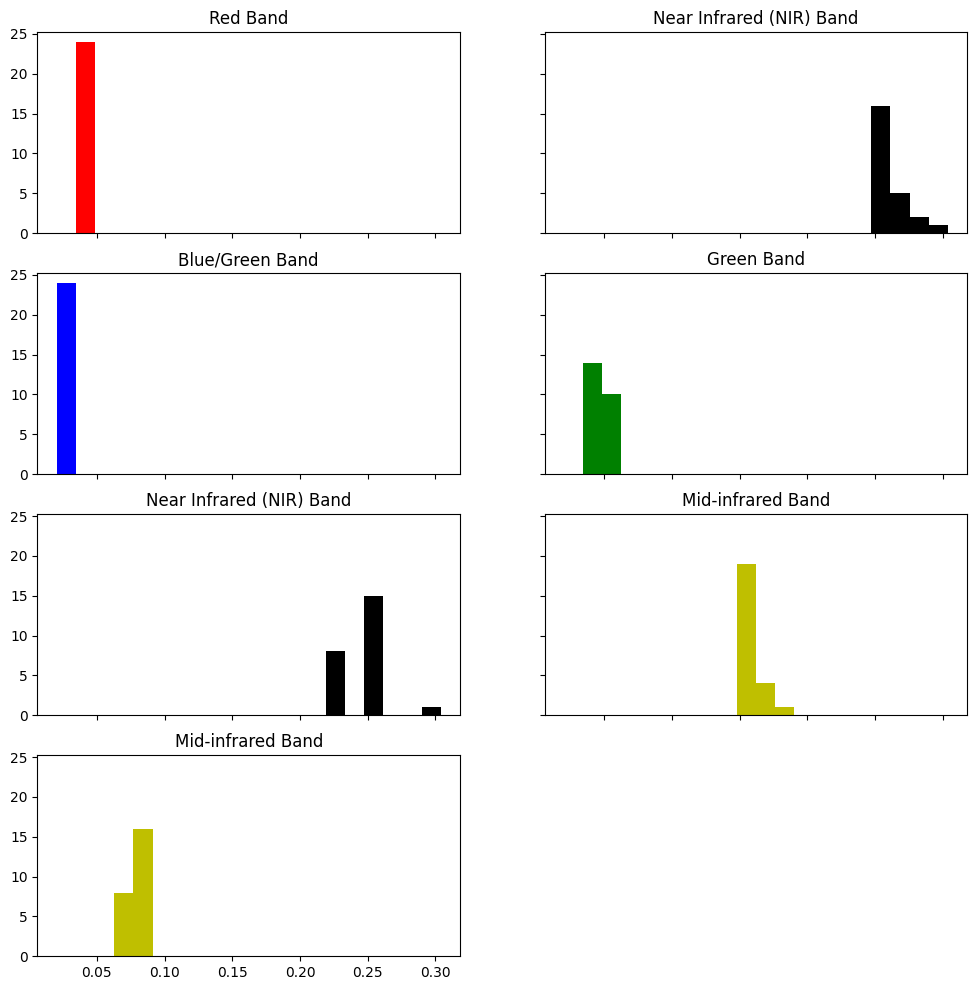

In [16]:
colors = ['r', 'k', 'b', 'g', 'k', 'y', 'y']
titles = ["Red Band", "Near Infrared (NIR) Band", "Blue/Green Band", "Green Band",
          "Near Infrared (NIR) Band", "Mid-infrared Band", "Mid-infrared Band"]

ep.hist(modis_bands_pre_scaled.values,
        colors=colors,
        title=titles,
        cols=2)
plt.show()